 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 4: Optimisation sans contraintes et méthodes itératives
Tangi Migot

In [2]:
using LinearAlgebra, Krylov, NLPModels, Printf, Logging, SolverCore, Test, ADNLPModels

## Exercice 0: Introduction aux NLSModels

On a vu dans les lab précédents l'utilisation des NLPModels pour représenter un problème d'optimisation. Dans le cas de l'optimisation de moindre carrées non-linéaires, il existe un type spécifique: **NLSModel**.

$\min_x \frac{1}{2} \| F(x) \|^2$

Comme un NLPModel classique on peut faire appels aux fonctions: obj, grad, hprod ...

Mais on peut aussi utiliser des fonctions relatives à $F$:
https://juliasmoothoptimizers.github.io/NLPModels.jl/stable/#Nonlinear-Least-Squares

In [8]:
? NLPModels.residual

ErrorException: syntax: invalid identifier name "?"

L'équivalent des ADNLPModel pour ce cas est la fonction: ADNLSModel.
Lien vers le site: https://juliasmoothoptimizers.github.io/ADNLPModels.jl/stable/

In [7]:
? ADNLPModels.ADNLSModel

ErrorException: syntax: invalid identifier name "?"

En utilisant les ADNLSModels écrire un modèle dont la fonction résidue est donné par FH ci-dessous.

In [6]:
#Test problem:
FH(x) = [x[2]+x[1].^2-11, x[1]+x[2].^2-7]
x0H = [10., 20.]
###########################
#Utilise FH et x0H pour créer un ADNLSModel
himmelblau_nls = ADNLSModel(FH, x0H, 2)
###########################

ADNLSModel - Nonlinear least-squares model with automatic differentiation backend ADNLPModels.ForwardDiffAD{ForwardDiff.GradientConfig{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}}}}(3, 0, ForwardDiff.GradientConfig{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}}}((Partials(1.0, 0.0), Partials(0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}[Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}}(0.0,0.0,0.0), Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}}(0.0,0.0,0.0)]))
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0        All residuals: ████████████████████ 2     
            free: █

## Exercice 1: Gauss-Newton

Dans cet exercice, on complète une implémentation de la méthode Gauss-Newton avec région de confiance discutée en cours.

Il faut compléter les morceaux:
- utiliser les fonctions des NLSModels pour obtenir F et sa jacobienne (ici on utilise pas la jacobienne mais juste le produit jacobienne-vecteur).
- Utiliser la fonction `lsmr` du package `Krylov.jl` pour résoudre le système linéaire avec une contrainte de `radius`.

In [3]:
function gauss_newton(nlp      :: AbstractNLSModel, 
                      x        :: AbstractVector, 
                      ϵ        :: AbstractFloat;
                      η₁       :: AbstractFloat = 1e-3, 
                      η₂       :: AbstractFloat = 0.66, 
                      σ₁       :: AbstractFloat = 0.25, 
                      σ₂       :: AbstractFloat = 2.0,
                      max_eval :: Int = 1_000, 
                      max_time :: AbstractFloat = 60.,
                      max_iter :: Int = typemax(Int64)
                      )
    ######################################################
    Fx = residual(nlp, x)
    Jx = jac_residual(nlp, x)
    ######################################################
    normFx = norm(Fx)

    Δ = 1.

    iter = 0    

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(Jx' * Fx)
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #################################
        #Compute the a direction satisfying the trust-region constraint
        (d, stats)  = lsmr(Jx, -Fx)
        #################################
      
        too_small = norm(d) < 1e-15
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     = residual(nlp, xp)
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                Δ = max(1e-8, Δ * σ₁)
                status = :reduce_Δ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp, x)
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂ && norm(d) >= 0.99 * Δ
                    Δ *= σ₂
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), Δ])

        el_time      = time() - start_time
        iter   += 1

        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp, status = status, solution = x,
                                 objective = normFx^2 / 2,
                                 dual_feas = normdual,
                                 iter = iter,
                                 elapsed_time = el_time)
end

gauss_newton (generic function with 1 method)

In [7]:
#A décommenter
stats = gauss_newton(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   1.0e+02          success   1.1e+01   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   2.4e+01          success   5.2e+00   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   4.9e+00          success   2.2e+00   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   7.0e-01          success   8.5e-01   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      4       6   2.8e-02          success   1.7e-01   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      5       7   5.1e-05          success   7.2e-03   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      6    

Test Passed

In [4]:
#Problèmes tests supplémentaires
@testset "Test set for Gauss-Newton" begin
    FH(x) = [x[2]+x[1].^2-11, x[1]+x[2].^2-7]
    x0H = [10., 20.]
    himmelblau_nls = ADNLSModel(FH, x0H, 2)

    F1(x) = [x[1], 0., 0.]
    problem2_nls = ADNLSModel(F1, ones(3), 3)

    Froz(x) = [10 * (x[2] - x[1]^2), x[1] - 1.0]
    rosenbrock_nls = ADNLSModel(Froz, [-1.2, 1.0], 2)

    n = 10
    F_larger(x) = [[10 * (x[i+1] - x[i]^2) for i = 1:n-1]; [x[i] - 1 for i = 1:n-1]]
    x0_larger = 0.9 * ones(n)
    larger_nls = ADNLSModel(F_larger, x0_larger, length(F_larger(x0_larger)))


    ######################################### TEST Gauss-Newton ##################

    #Unit/Validation Tests
    using Logging, Test
    for nls in [rosenbrock_nls, problem2_nls, himmelblau_nls, larger_nls]
        x = 4*ones(nls.meta.nvar)
        @time stats = gauss_newton(nls, x, 1e-6)
        @test stats.status == :first_order
    end
end

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:31


┌ Info:      0       2   9.0e+01          success   1.2e+01   1.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   1.6e-11          success   9.0e+00   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72


  4.190861 seconds (13.52 M allocations: 676.034 MiB, 10.71% gc time, 99.63% compilation time)


  0.447405 seconds (2.80 M allocations: 140.702 MiB, 6.92% gc time, 99.69% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   0.0e+00          success   4.0e+00   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72


  0.491906 seconds (2.80 M allocations: 140.589 MiB, 7.38% gc time, 99.66% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   2.4e+00          success   1.8e+00   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   2.0e-01          success   4.5e-01   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   2.4e-03          success   5.0e-02   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   4.0e-07          success   6.4e-04   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72


  0.557499 seconds (2.92 M allocations: 145.752 MiB, 6.51% gc time, 99.56% compilation time)

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   1.3e+02          success   1.5e+01   2.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   1.9e+01          success   1.0e+01   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   3.3e+00          success   9.8e-01   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   2.4e-01          success   2.5e-01   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      4       6   1.8e-03          success   2.1e-02   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72
┌ Info:      5       7   1.1e-07          success   1.5e-04   4.0e+00
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:72



Test Summary:             | Pass  Total  Time
Test set for Gauss-Newton |    4      4  8.7s


Test.DefaultTestSet("Test set for Gauss-Newton", Any[], 4, false, false, true, 1.678376511698e9, 1.67837652035e9)

## Exercice 2: Méthode Levenberg-Marquard inexacte

Dans cet exercice, on complète une implémentation de la méthode Levenberg-Marquardt. Pour compléter le code `lm_param` on va utiliser les fonctions suivantes:
- `dsol` qui calcul la solution du système 
$\min_x \frac{1}{2}\|JF(x) d + F(x)\| + \lambda \|x\|^2$
avec la fonction `lsqr` du package `Krylov.jl`.
- `multi_sol` qui pour un entier nl donné et un $\mu$ va résoudre le problème de dsol pour nl valeurs de $\lambda$ (autour de la valeur $\mu$). Par exemple, pour $\mu=10^{-6}$ et $nl=3$, on prendra $\lambda=10^{-7}, 10^{-6},10^{-5}$.
Parmis les `nl` directions calculées, on retourne celle qui donne la plus petite valeur de $\|F(x+d)\|^2$.

In [15]:
function dsol(Fx, Jx, λ, τ)
    (d, stats) = lsqr(Jx, -Fx, λ = λ, atol = τ)
    return d
end

dsol (generic function with 1 method)

In [21]:
function multi_sol(nlp, x, Fx, Jx, λ, τ; nl = 3)
    (d, stats) = lsqr(Jx, -Fx, λ = λ * 10^((1 - nl) / 2), atol = τ)
    F_best = norm(residual(nlp, x + d))
    d_best = d
    if nl > 1
        for i=2:nl
            (d, stats) = lsqr(Jx, -Fx, λ = λ * 10^(i - (nl + 1) / 2), atol = τ)
            F_norm = norm(residual(nlp, x + d))
            if F_norm < F_best
                F_best = F_norm
                d_best = d
            end
        end
    end
    return d_best
end

multi_sol (generic function with 1 method)

In [22]:
function lm_param(nlp      :: AbstractNLSModel, 
                  x        :: AbstractVector, 
                  ϵ        :: AbstractFloat;
                  η₁       :: AbstractFloat = 1e-3, 
                  η₂       :: AbstractFloat = 0.66, 
                  σ₁       :: AbstractFloat = 10.0, 
                  σ₂       :: AbstractFloat = 0.5,
                  max_eval :: Int = 10_000, 
                  max_time :: AbstractFloat = 60.,
                  max_iter :: Int = typemax(Int64)
                  )
    ######################################################
    Fx = residual(nlp, x)
    Jx = jac_residual(nlp, x)
    ######################################################
    normFx   = norm(Fx)
    normdual = norm(Jx' * Fx)

    iter = 0    
    λ = 0.0
    λ₀ = 1e-6
    η = 0.5
    τ = η * normdual

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :λ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        ###########################
        # (d, stats)  = lsqr(Jx, -Fx, λ = λ, atol = τ)
        d = multi_sol(nlp, x, Fx, Jx, λ, τ)
        ###########################
        
        too_small = norm(d) < 1e-16
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     = residual(nlp, xp)
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2 - λ*norm(d)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                λ = max(λ₀, σ₁ * λ)
                status = :increase_λ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp, x)
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂
                    λ = max(λ * σ₂, λ₀)
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), λ])

        el_time      = time() - start_time
        iter        += 1
        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ

        η = λ == 0.0 ? min(0.5, 1/iter, normdual) : min(0.5, 1/iter)
        τ = η * normdual
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp, status = status, solution = x,
                                 objective = normFx^2 / 2,
                                 dual_feas = normdual,
                                 iter = iter,
                                 elapsed_time = el_time)
end

lm_param (generic function with 1 method)

In [23]:
#A décommenter
stats = lm_param(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:33


┌ Info:      0      23   1.2e+02          success   1.0e+01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      1      27   2.9e+01          success   6.0e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      31   5.3e+00          success   2.6e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      35   1.4e+00          success   7.4e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      39   1.7e-01          success   3.4e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      5      43   5.2e-02          success   2.5e-02   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      6      47   1.7e-04          success   1.4e-02   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      7      

Test Passed

In [24]:
#Problèmes tests supplémentaires
@testset "Test set for LM" begin
    FH(x) = [x[2]+x[1].^2-11, x[1]+x[2].^2-7]
    x0H = [10., 20.]
    himmelblau_nls = ADNLSModel(FH, x0H, 2)

    F1(x) = [x[1], 0., 0.]
    problem2_nls = ADNLSModel(F1, ones(3), 3)

    Froz(x) = [10 * (x[2] - x[1]^2), x[1] - 1.0]
    rosenbrock_nls = ADNLSModel(Froz, [-1.2, 1.0], 2)

    n = 10
    F_larger(x) = [[10 * (x[i+1] - x[i]^2) for i = 1:n-1]; [x[i] - 1 for i = 1:n-1]]
    x0_larger = 0.9 * ones(n)
    larger_nls = ADNLSModel(F_larger, x0_larger, length(F_larger(x0_larger)))

    for nls in [rosenbrock_nls, problem2_nls, himmelblau_nls, larger_nls]
        x = 4*ones(nls.meta.nvar)
        @time stats2 = lm_param(nls, x, 1e-6)
        @test stats.status == :first_order
    end
end

  0.854090 seconds (2.58 M allocations: 128.353 MiB, 6.15% gc time, 99.05% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   2.2e+01          success   1.5e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   2.0e+00          success   4.2e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      13   1.1e+00          success   4.0e-02   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      17   1.1e+00       increase_λ   4.5e+00   1.0e-05
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      21   1.1e+00       increase_λ   4.5e+00   1.0e-04
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      5      25   1.1e+00       increase_λ   4.5e+00   1.0e-03
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      6    

  0.592760 seconds (2.69 M allocations: 134.309 MiB, 10.55% gc time, 99.73% compilation time)

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   0.0e+00          success   4.0e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   2.7e+00          success   1.8e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   1.0e+00          success   4.3e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      13   4.7e-01          success   1.9e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      17   1.2e-02          success   1.1e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      21   9.3e-06          success   3.1e-03   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      5      25   5.8e-12          success   2.4e-06   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74


  0.561607 seconds (2.61 M allocations: 129.816 MiB, 11.37% gc time, 99.56% compilation time)
  0.662065 seconds (2.78 M allocations: 138.596 MiB, 7.57% gc time, 98.77% compilation time)
Test Summary:   | Pass  Total  Time
Test set for LM |    4      4  3.7s


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   8.8e+01          success   5.0e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   2.1e+01          success   2.3e+00   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      13   4.4e+00          success   9.3e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      17   1.3e+00          success   2.7e-01   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      21   1.2e+00          success   3.4e-02   1.0e-06
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      5      25   1.2e+00       increase_λ   4.8e+00   1.0e-05
└ @ Main c:\Users\Goglu\GitClones\MTH8408\lab4\Lab4-notebook.ipynb:74
┌ Info:      6    

Test.DefaultTestSet("Test set for LM", Any[], 4, false, false, true, 1.67690897279e9, 1.676908976455e9)

## Exercice 3: Rocket Control

Dans les cellules ci-dessous nous introduisons un modèle de contrôle optimal (cf. https://en.wikipedia.org/wiki/Optimal_control ) pour le contrôle d'une fusée dont une version discrétisée a été modélisé avec JuMP:

Le lien vers le tutoriel:
https://nbviewer.jupyter.org/github/jump-dev/JuMPTutorials.jl/blob/master/notebook/modelling/rocket_control.ipynb

In [25]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

In [26]:
# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

Solving...



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Max height: 1.0128340648308065


In [27]:
value.(h)[n]

1.0128340648308065

In [30]:
# Can visualize the state and control variables
using Gadfly

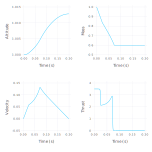

In [31]:
h_plot = plot(x = (1:n) * value.(Δt), y = value.(h)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt), y = value.(m)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt), y = value.(v)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt), y = value.(T)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

### Questions:     
    - i) Transformer le modèle JuMP utilisé ci-dessus en un NLPModel en utilisant le package `NLPModelsJuMP`.    
    - ii) Résoudre ce nouveau modèle avec `Ipopt` en utilisant `NLPModelsIpopt`.    
    - iii) Calcul séparément la différence entre les h,v,m,T, Δt calculés.    
    - iv) Est-ce que le contrôle T atteint ses bornes ?    
    - v) Reproduire les graphiques ci-dessous avec la solution calculée via `NLPModelsIpopt`.


In [58]:
using NLPModels, LinearAlgebra, NLPModelsJuMP, NLPModelsIpopt

NLP_rocket = MathOptNLPModel(rocket)
stats = ipopt(NLP_rocket)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15185
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45543

Total number of variables............................:     3201
                     variables with only lower bounds:     1601
                variables with lower and upper bounds:     1600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2401
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.96e-01 2.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [63]:
Δt_nlp = stats.solution[1];
v_nlp = stats.solution[2:801];
h_nlp = stats.solution[802:1601];
m_nlp = stats.solution[1602:2401];
T_nlp = stats.solution[2402:3201];

Δv = maximum(value.(v)[:] - v_nlp)
Δh = maximum(value.(h)[:] - h_nlp)
Δm = maximum(value.(m)[:] - m_nlp)
ΔT = maximum(value.(T)[:] - T_nlp)

print(Δv, Δh, Δm, ΔT)


0.00.00.00.0

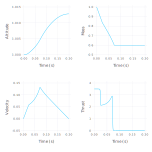

In [59]:
h_plot_nlp = plot(x = (1:n) * Δt_nlp, y = h_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot_nlp = plot(x = (1:n) * Δt_nlp, y = m_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot_nlp = plot(x = (1:n) * Δt_nlp, y = v_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot_nlp = plot(x = (1:n) * Δt_nlp, y = T_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot_nlp, m_plot_nlp), hstack(v_plot_nlp, T_plot_nlp)))